In [2]:
import pathlib
import re

import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.svm
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import tabulate
import tensorflow as tf
#plt.style.use("slides")
from scipy import stats
from tensorflow.python.keras.metrics import binary_accuracy

from link_bot_data.visualization import color_violinplot, noisey_1d_scatter
from moonshine.gpu_config import limit_gpu_mem
from moonshine.moonshine_utils import repeat_tensor
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True, linewidth=250)


limit_gpu_mem(0.5)

In [3]:
def myshorten(string: str):
    parts = re.split("/", string)
    indices = [3]
    shortened = '-'.join([parts[i] for i in indices])
    return shortened

infiles = {
'car': 'results/classifier_data/val_car_feasible_1614981888/val_car_feasible_ensemble/results_1616172209.npz',
'empty': 'results/classifier_data/results/empty1/val_car_feasible_ensemble/results_1616173437.npz',
'long hook': 'results/classifier_data/val_long_hook_1616587237/none/results_1617288616.npz',
'ring': 'results/classifier_data/val_ring_1617119744/none/results_1617289835.npz',
'deadend': 'results/classifier_data/val_deadend_1617235474/val_car_feasible_ensemble/results_1617291138.npz',
'slit': 'results/classifier_data/val_slit_1617224535/val_car_feasible_ensemble/results_1617290819.npz',
# 'full': '',
    # OLD DATASETS
# 'rack' : 'results/classifier_data/val_rack_1616169743/none/results_1616179679.npz',
# 'planning, party' : 'results/classifier_data/results/party1/none/results_1616175621.npz',
# 'planning, car': 'results/classifier_data/results/fss-no-starts-far-classifier-1/val_car_feasible_ensemble/',
}


dfs = {}
for name, infile in infiles.items():
    infile_path = pathlib.Path(infile)
    df = np.load(infile)
    print(name, list(df.keys()))

    actual_data_keys = [
        'stdevs',
        'is_correct',
        'probabilities',
        'labels',
        'error',
    ]
    actual_data = {k : df[k] for k in actual_data_keys}

    df = pd.DataFrame(data=actual_data)
    dfs[name] = df

names = list(dfs.keys())

car ['stdevs', 'is_correct', 'probabilities', 'labels', 'checkpoints', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
empty ['stdevs', 'is_correct', 'probabilities', 'labels', 'checkpoints', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
long hook ['stdevs', 'is_correct', 'probabilities', 'labels', 'ensemble_path', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
ring ['stdevs', 'is_correct', 'probabilities', 'labels', 'ensemble_path', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
deadend ['stdevs', 'is_correct', 'probabilities', 'labels', 'ensemble_path', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']
slit ['stdevs', 'is_correct', 'probabilities', 'labels', 'ensemble_path', 'dataset', 'balance', 'error', 'mode', 'use_gt_rope']


In [4]:
for name, df in dfs.items():
    print(df)

         stdevs  is_correct  probabilities  labels     error
0      0.245228       False       0.262635     1.0  0.040998
1      0.000430        True       0.000354     0.0  0.159969
2      0.000179        True       0.000340     0.0  0.147804
3      0.001308        True       0.998961     1.0  0.024696
4      0.014050        True       0.991813     1.0  0.022849
...         ...         ...            ...     ...       ...
36539  0.010938        True       0.990109     1.0  0.024242
36540  0.000278        True       0.999791     1.0  0.016702
36541  0.000067        True       0.000125     0.0  0.280492
36542  0.007699        True       0.996123     1.0  0.013666
36543  0.000153        True       0.000146     0.0  0.218336

[36544 rows x 5 columns]
       stdevs  is_correct  probabilities  labels     error
0    0.196175       False       0.870169     0.0  0.057227
1    0.000047        True       0.999944     1.0  0.026651
2    0.000242        True       0.999791     1.0  0.028010
3    0

In [5]:
table = []
for name, df in dfs.items():
    stdevs = df['stdevs']
    table.append((name, stdevs.mean(), stdevs.std()))
print(tabulate.tabulate(table, headers=['name', 'mean', 'std'], floatfmt='.3f'))


name         mean    std
---------  ------  -----
car         0.063  0.113
empty       0.070  0.105
long hook   0.101  0.126
ring        0.111  0.133
deadend     0.109  0.130
slit        0.106  0.127


In [6]:
# Can the mean output probability of the ensemble tell us whether the classifier is wrong?
# one problem with this analysis is that the class balance is going to be different between each plot,
# as well as between the correct/incorrect, so I'm not sure I can interpret these results correctly.
def make_max_class_prob(probabilities):
    other_class_probabilities = 1 - probabilities
    return np.maximum(probabilities, other_class_probabilities)

stdev_normalizing_factor = np.max(dfs['car']['stdevs'])

def stdev_score(x, beta=1):
    x = x / stdev_normalizing_factor
    return 1 - beta * (x / (x + 1))

def combine_mcp_and_stdev_score(stdev_scores, mcp):
    alpha = 0.7
    return alpha * stdev_scores + (1 - alpha) * mcp
    # return np.maximum(alpha * stdev_scores, (1 - alpha) * mcp)

def compute_widths(datasets):
    sizes = np.array([d.size for d in datasets])
    return sizes / np.max(sizes)

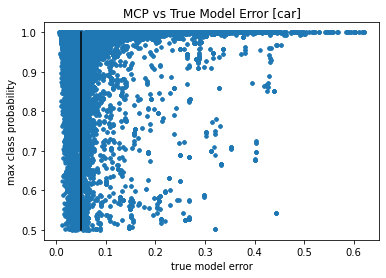

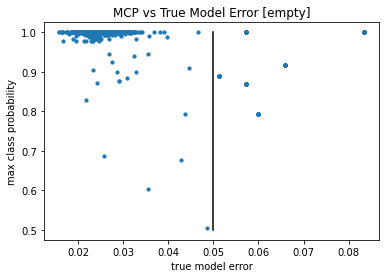

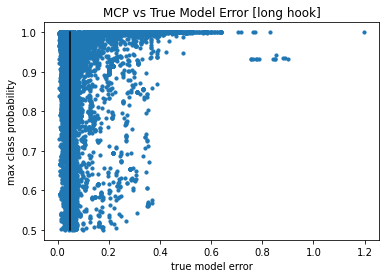

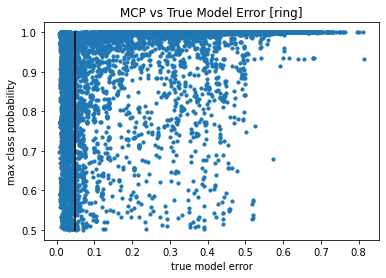

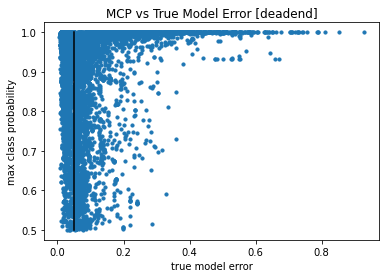

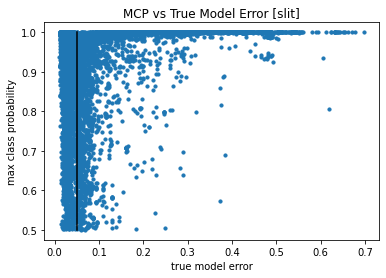

In [7]:
# Is max class probabilities to correlated with error??
for name, df in dfs.items():
    probabilities = df['probabilities']
    error = df['error']

    max_class_probabilities = make_max_class_prob(probabilities)

    _, ax = plt.subplots()
    ax.set_title(f'MCP vs True Model Error [{name}]')
    ax.scatter(error, max_class_probabilities, s=10)
    ax.plot([0.05, 0.05], [0.5, 1.0], c='k')
    ax.set_xlabel("true model error")
    ax.set_ylabel("max class probability")

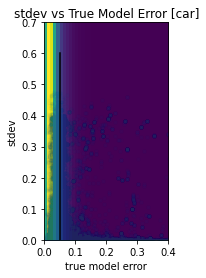

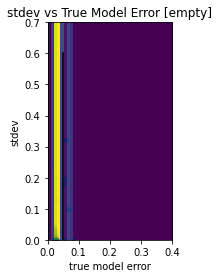

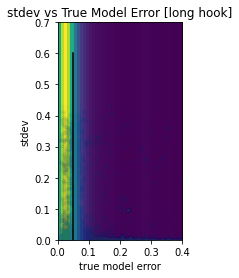

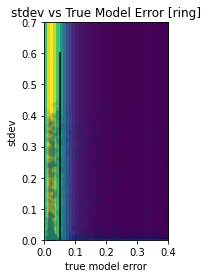

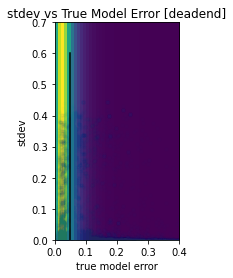

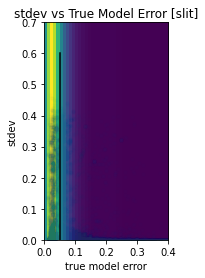

In [8]:
# Is ensemble stdev to correlated with error??
for name, df in dfs.items():
    stdevs = df['stdevs']
    error = df['error']

    xmin = 0
    xmax = 0.4
    ymin = 0
    ymax = 0.7
    xs, ys = np.mgrid[xmin:xmax:0.01, ymin:ymax:0.01]
    positions = np.vstack([xs.ravel(), xs.ravel()])
    values = np.vstack([error, stdevs])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, xs.shape)

    _, ax = plt.subplots()
    ax.scatter(error, stdevs, s=10, alpha=0.01)
    ax.plot([0.05, 0.05], [0.0, 0.6], c='k')
    ax.imshow(np.rot90(Z), extent=[xmin, xmax, ymin, ymax])
    ax.set_title(f'stdev vs True Model Error [{name}]')
    ax.set_xlabel("true model error")
    ax.set_ylabel("stdev")

In [28]:
# how accurately can we predict error given stdev and mcp??
for name, df in dfs.items():
    stdevs = df['stdevs']
    error = df['error']
    is_correct = df['is_correct']
    probabilities = df['probabilities']

    mcp = make_max_class_prob(probabilities)

    X=np.stack([stdevs, mcp], axis=1)
    y=is_correct

    # reg = sklearn.linear_model.LinearRegression().fit(X, y)
    # print(name, reg.score(X, y))

    svm = sklearn.svm.SVC(kernel='linear').fit(X, y)
    y_hat = svm.predict(X)
    accuracy = np.count_nonzero(y_hat == y) / y.shape[0]
    print(name, accuracy)
    # fig = plt.figure()
    # ax = plt.axes(projection='3d')
    # ax.scatter(mcp, stdevs, error, s=10, alpha=0.01)
    # ax.set_title(f'stdev vs True Model Error [{name}]')
    # ax.set_xlabel("stdev")
    # ax.set_ylabel("true model error")

car 0.9072624781085814
empty 0.8196022727272727
long hook 0.8595753205128205
ring 0.9200721153846154
deadend 0.8889222756410257
slit 0.9153645833333334


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


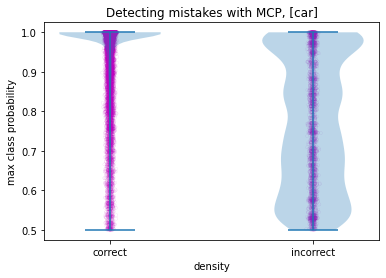

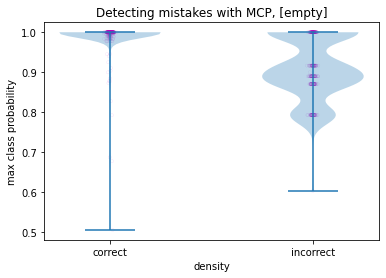

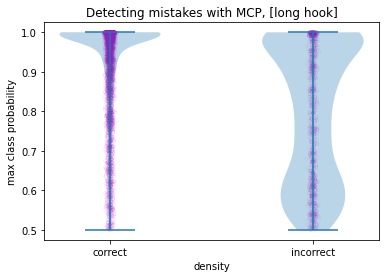

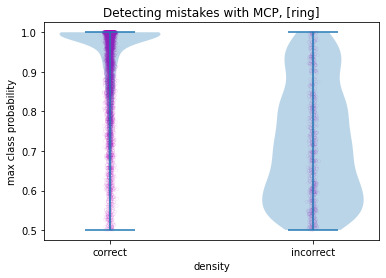

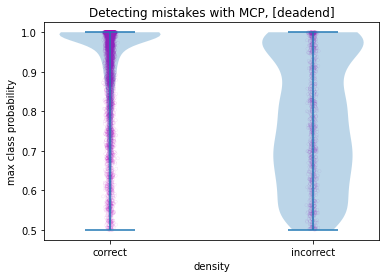

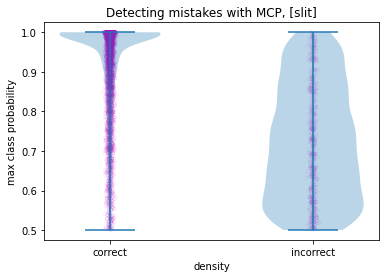

In [10]:
# Can we use the max class probabilities to determine if the classifier is wrong?
for name, df in dfs.items():
    probabilities = df['probabilities']
    is_correct = df['is_correct']

    is_correct_indices = np.argwhere(is_correct).squeeze()
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct)).squeeze()

    max_class_probabilities_correct = make_max_class_prob(probabilities[is_correct_indices].squeeze())
    max_class_probabilities_incorrect = make_max_class_prob(probabilities[is_incorrect_indices].squeeze())

    _, ax = plt.subplots()
    ax.set_title(f'Detecting mistakes with MCP, [{name}]')
    noisey_1d_scatter(ax,
                      max_class_probabilities_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    noisey_1d_scatter(ax, max_class_probabilities_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)

    # widths = compute_widths([max_class_probabilities_correct, max_class_probabilities_incorrect])
    widths = [0.5, 0.5]
    ax.violinplot([max_class_probabilities_correct, max_class_probabilities_incorrect], [1, 2], widths=widths)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("max class probability")

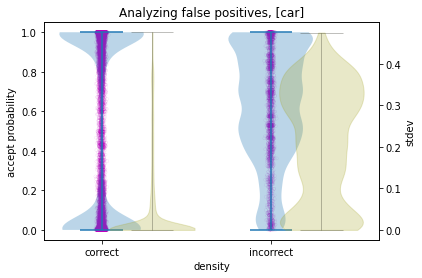

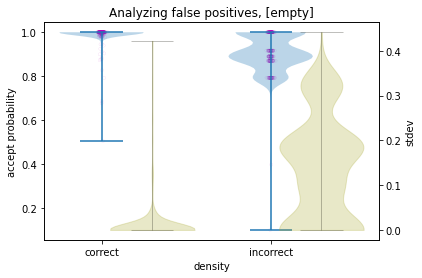

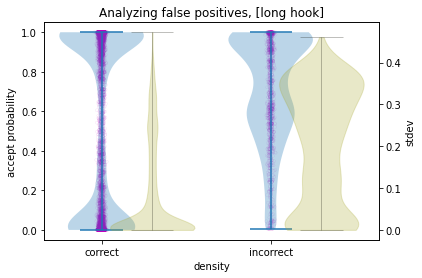

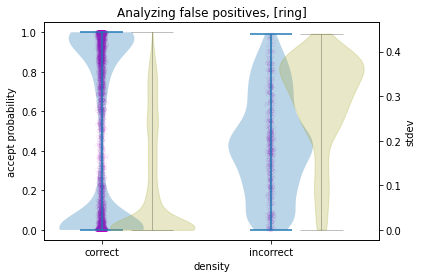

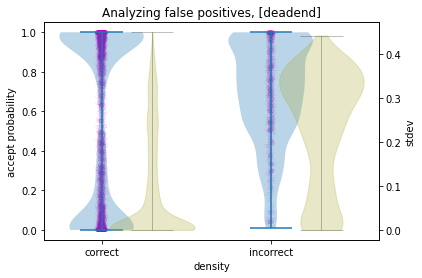

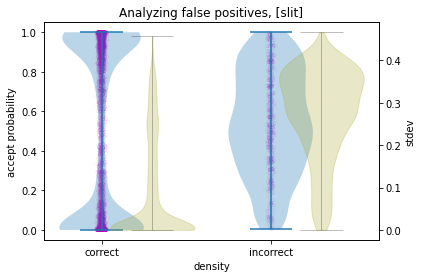

In [11]:
# Analysing false positives
for name, df in dfs.items():
    probabilities = df['probabilities']
    is_correct = df['is_correct']
    stdevs = df['stdevs']

    is_correct_indices = np.argwhere(is_correct).squeeze()
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct)).squeeze()

    probabilities_correct = probabilities[is_correct_indices].squeeze()
    probabilities_incorrect = probabilities[is_incorrect_indices].squeeze()
    stdev_scores_correct = stdevs[is_correct_indices].squeeze()
    stdev_scores_incorrect = stdevs[is_incorrect_indices].squeeze()

    _, ax = plt.subplots()
    ax.set_title(f'Analyzing false positives, [{name}]')
    ax2 = ax.twinx()
    noisey_1d_scatter(ax, probabilities_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    noisey_1d_scatter(ax, probabilities_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    # widths = compute_widths([probabilities_correct, probabilities_incorrect])
    widths = [0.5, 0.5]
    ax.violinplot([probabilities_correct, probabilities_incorrect], [1, 2], widths=widths)
    parts = ax2.violinplot([stdev_scores_correct, stdev_scores_incorrect], [1.3, 2.3], widths=widths)
    color_violinplot(parts, color='#aaaa3344')
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("accept probability")
    ax2.set_ylabel("stdev")


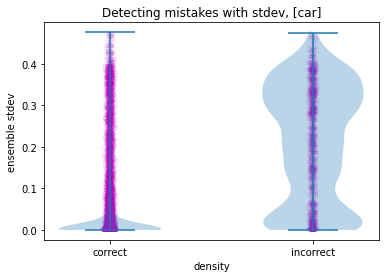

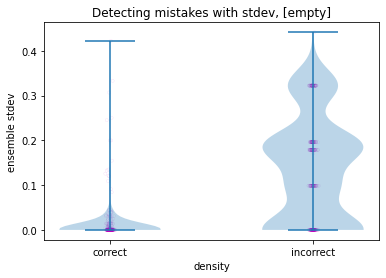

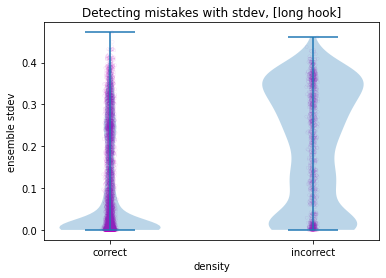

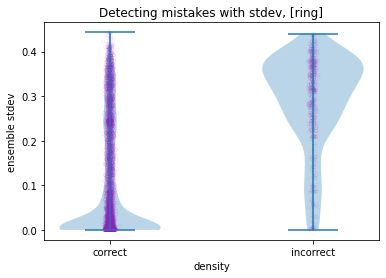

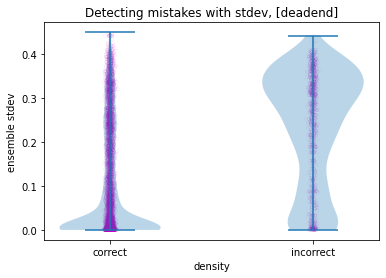

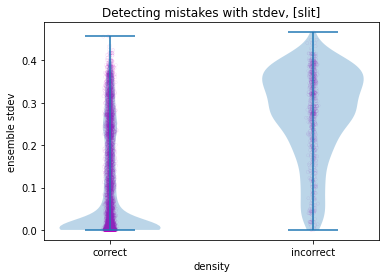

In [12]:
# Can the ensemble stdev tell us whether the classifier is wrong?

for name, df in dfs.items():
    stdevs = df['stdevs']
    is_correct = df['is_correct']

    is_correct_indices = np.argwhere(is_correct).squeeze()
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct)).squeeze()

    stdevs_correct = stdevs[is_correct_indices].squeeze()
    stdevs_incorrect = stdevs[is_incorrect_indices].squeeze()

    _, ax = plt.subplots()
    ax.set_title(f'Detecting mistakes with stdev, [{name}]')
    noisey_1d_scatter(ax, stdevs_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    noisey_1d_scatter(ax, stdevs_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    # widths = compute_widths([stdevs_correct, stdevs_incorrect])
    widths = [0.5, 0.5]
    ax.violinplot([stdevs_correct, stdevs_incorrect], [1, 2], widths=widths)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("ensemble stdev")

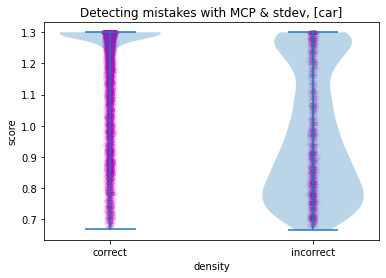

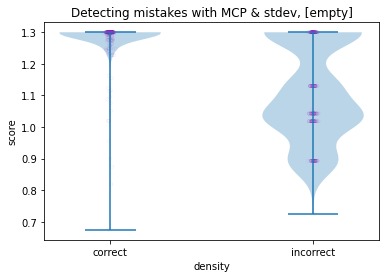

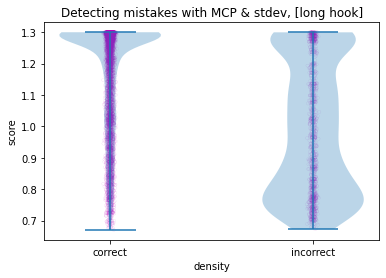

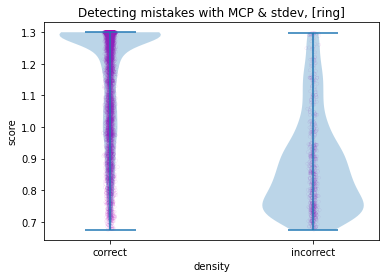

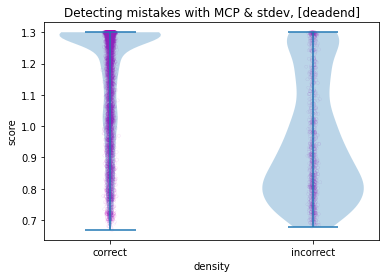

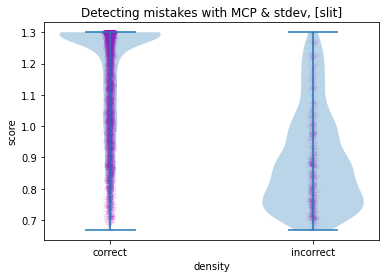

In [13]:
# Can the mean & stdev of ensemble together tell us whether the classifier is wrong?

for name, df in dfs.items():
    probabilities = df['probabilities']
    stdevs = df['stdevs']
    is_correct = df['is_correct']

    is_correct_indices = np.argwhere(is_correct).squeeze()
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct)).squeeze()

    # unbounded
    stdevs_correct = stdevs[is_correct_indices].squeeze()
    stdevs_incorrect = stdevs[is_incorrect_indices].squeeze()

    # ranges from 0 to 1
    max_class_probabilities_correct = make_max_class_prob(probabilities[is_correct_indices].squeeze()) * 2
    max_class_probabilities_incorrect = make_max_class_prob(probabilities[is_incorrect_indices].squeeze()) * 2
    combined_score_correct = combine_mcp_and_stdev_score(stdev_score(stdevs_correct), max_class_probabilities_correct)
    combined_score_incorrect = combine_mcp_and_stdev_score(stdev_score(stdevs_incorrect), max_class_probabilities_incorrect)

    _, ax = plt.subplots()
    ax.set_title(f'Detecting mistakes with MCP & stdev, [{name}]')
    noisey_1d_scatter(ax, combined_score_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    noisey_1d_scatter(ax, combined_score_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    # widths = compute_widths([combined_score_correct, combined_score_incorrect])
    widths = [0.5, 0.5]
    ax.violinplot([combined_score_correct, combined_score_incorrect], [1, 2], widths=widths)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("score")

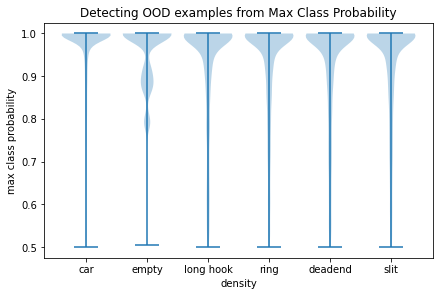

In [14]:
# Can the mean output probability of the ensemble tell us whether the input is OOD?

max_class_probabilities_across_dataset = [make_max_class_prob(v['probabilities']) for v in dfs.values()]
positions = np.arange(len(dfs))

_, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from Max Class Probability")
ax.violinplot(max_class_probabilities_across_dataset, positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("max class probability")
plt.savefig("ood_from_mcp.jpeg")

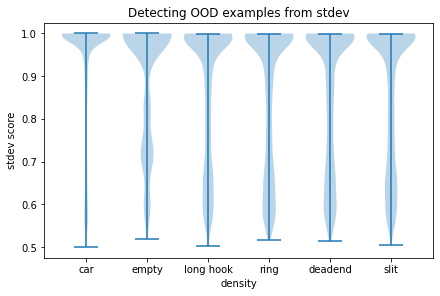

In [15]:
# Can the ensemble stdev tell us whether the input is OOD?

stdevs_across_dataset = [v['stdevs'] for v in dfs.values()]
positions = list(range(len(dfs)))

_, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from stdev")
ax.violinplot(stdev_score(stdevs_across_dataset), positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("stdev score")
plt.savefig("ood_from_stdev.jpeg")

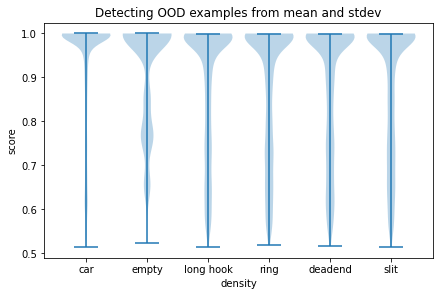

In [16]:
# Can the mean & stdev of ensemble together tell us whether the input is OOD?

probabilities_across_dataset = [v['probabilities'] for v in dfs.values()]
max_class_probabilities_across_dataset = np.array([make_max_class_prob(v['probabilities']) for v in dfs.values()])

stdevs_across_dataset = np.array([v['stdevs'] for v in dfs.values()])
scores_across_dataset = combine_mcp_and_stdev_score(stdev_score(stdevs_across_dataset), max_class_probabilities_across_dataset)
positions = list(range(len(dfs)))

_, ax = plt.subplots(constrained_layout=True)
ax.set_title("Detecting OOD examples from mean and stdev")
ax.violinplot(scores_across_dataset, positions, widths=0.8)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_xlabel("density")
ax.set_ylabel("score")
plt.savefig("ood_from_score.jpeg")


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a 

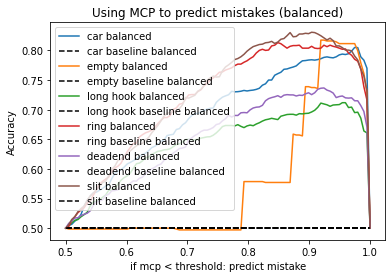

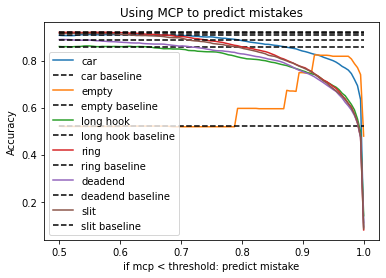

In [17]:
_, ax1 = plt.subplots()
ax1.set_title(f"Using MCP to predict mistakes (balanced)")
ax1.set_xlabel("if mcp < threshold: predict mistake")
ax1.set_ylabel("Accuracy")
_, ax2 = plt.subplots()
ax2.set_title(f"Using MCP to predict mistakes")
ax2.set_xlabel("if mcp < threshold: predict mistake")
ax2.set_ylabel("Accuracy")

def compute_accuracy_at_thresholds(y_pred, y_true):
    n_thresholds = 100
    thresholds = np.linspace(0.5, 1, n_thresholds)
    thresholds_repeated = repeat_tensor(thresholds, repetitions=y_true.shape[0], axis=1, new_axis=True)
    is_correct_repeated = repeat_tensor(y_true, repetitions=n_thresholds, axis=0, new_axis=True)
    y_pred_repeated = repeat_tensor(y_pred, repetitions=n_thresholds, axis=0, new_axis=True)
    predictions_at_threshold = tf.cast(y_pred_repeated > thresholds_repeated, tf.float32)
    predictions_at_threshold = tf.expand_dims(predictions_at_threshold, axis=-1)
    is_correct_repeated = tf.expand_dims(is_correct_repeated, axis=-1)
    accuracy_at_thresholds = tf.reduce_mean(binary_accuracy(is_correct_repeated, predictions_at_threshold), axis=1)
    return accuracy_at_thresholds, thresholds

def balance(y_pred, y_true):
    pos_indices = np.nonzero(y_true)[0]
    neg_indices = np.nonzero(1 - y_true)[0]
    pos = np.ones_like(pos_indices, dtype=np.float32)
    neg = np.zeros_like(neg_indices, dtype=np.float32)
    y_true_balanced = np.array(list(zip(pos.squeeze(), neg.squeeze()))).reshape(-1)
    y_pred_pos = y_pred[pos_indices]
    y_pred_neg = y_pred[neg_indices]
    y_pred_balanced = np.array(list(zip(y_pred_pos.squeeze(), y_pred_neg.squeeze()))).reshape(-1)
    return y_pred_balanced, y_true_balanced

for name, df in dfs.items():
    probabilities = df['probabilities']
    is_correct = df['is_correct'].astype(np.float32)

    mcp = make_max_class_prob(probabilities)

    mcp_balanced, is_correct_balanced = balance(mcp, is_correct)

    accuracy_at_thresholds, thresholds = compute_accuracy_at_thresholds(mcp, is_correct)
    accuracy_at_thresholds_balanced, _ = compute_accuracy_at_thresholds(mcp_balanced, is_correct_balanced)

    base_accuracy = np.count_nonzero(is_correct) / is_correct.shape[0]
    ax2.plot(thresholds, accuracy_at_thresholds, label=name)
    ax2.plot([0.5, 1.0], [base_accuracy, base_accuracy], c='k', linestyle='--', label=f'{name} baseline')

    ax1.plot(thresholds, accuracy_at_thresholds_balanced, label=f'{name} balanced')
    ax1.plot([0.5, 1.0], [0.5, 0.5], c='k', linestyle='--', label=f'{name} baseline balanced')

ax1.legend()
ax2.legend()

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a 

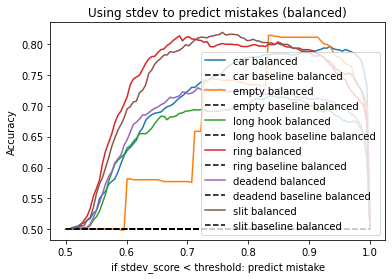

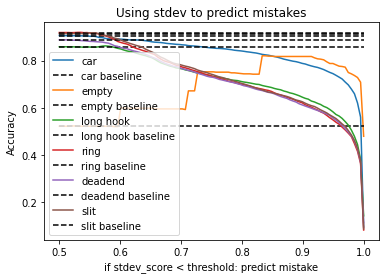

In [18]:
# PR Curve for using MCP to predict whether an example is classifier incorrectly
_, ax1 = plt.subplots()
ax1.set_title(f"Using stdev to predict mistakes (balanced)")
ax1.set_xlabel("if stdev_score < threshold: predict mistake")
ax1.set_ylabel("Accuracy")
_, ax2 = plt.subplots()
ax2.set_title(f"Using stdev to predict mistakes")
ax2.set_xlabel("if stdev_score < threshold: predict mistake")
ax2.set_ylabel("Accuracy")
for name, df in dfs.items():
    is_correct = df['is_correct'].astype(np.float32)
    stdevs = df['stdevs']

    stdev_scores = stdev_score(stdevs)

    stdev_scores_balanced, is_correct_balanced = balance(stdev_scores, is_correct)

    accuracy_at_thresholds, thresholds = compute_accuracy_at_thresholds(stdev_scores, is_correct)
    accuracy_at_thresholds_balanced, _ = compute_accuracy_at_thresholds(stdev_scores_balanced, is_correct_balanced)

    base_accuracy = np.count_nonzero(is_correct) / is_correct.shape[0]
    ax2.plot(thresholds, accuracy_at_thresholds, label=name)
    ax2.plot([0.5, 1.0], [base_accuracy, base_accuracy], c='k', linestyle='--', label=f'{name} baseline')

    ax1.plot(thresholds, accuracy_at_thresholds_balanced, label=f'{name} balanced')
    ax1.plot([0.5, 1.0], [0.5, 0.5], c='k', linestyle='--', label=f'{name} baseline balanced')

ax1.legend()
ax2.legend()

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a 

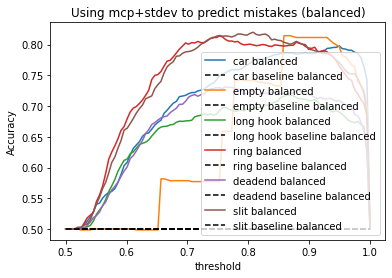

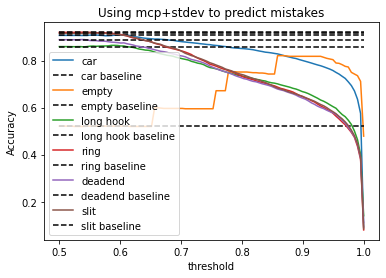

In [19]:
# using MCP + stdev to predict whether an example is classifier incorrectly
_, ax1 = plt.subplots()
ax1.set_title(f"Using mcp+stdev to predict mistakes (balanced)")
ax1.set_xlabel("threshold")
ax1.set_ylabel("Accuracy")
_, ax2 = plt.subplots()
ax2.set_title(f"Using mcp+stdev to predict mistakes")
ax2.set_xlabel("threshold")
ax2.set_ylabel("Accuracy")
for name, df in dfs.items():
    is_correct = df['is_correct'].astype(np.float32)
    stdevs = df['stdevs']
    probabilities = df['probabilities']

    scores = combine_mcp_and_stdev_score(stdev_score(stdevs), make_max_class_prob(probabilities))

    scores_balanced, is_correct_balanced = balance(scores, is_correct)

    accuracy_at_thresholds, thresholds = compute_accuracy_at_thresholds(scores, is_correct)
    accuracy_at_thresholds_balanced, _ = compute_accuracy_at_thresholds(scores_balanced, is_correct_balanced)

    base_accuracy = np.count_nonzero(is_correct) / is_correct.shape[0]
    ax2.plot(thresholds, accuracy_at_thresholds, label=name)
    ax2.plot([0.5, 1.0], [base_accuracy, base_accuracy], c='k', linestyle='--', label=f'{name} baseline')

    ax1.plot(thresholds, accuracy_at_thresholds_balanced, label=f'{name} balanced')
    ax1.plot([0.5, 1.0], [0.5, 0.5], c='k', linestyle='--', label=f'{name} baseline balanced')

ax1.legend()
ax2.legend()

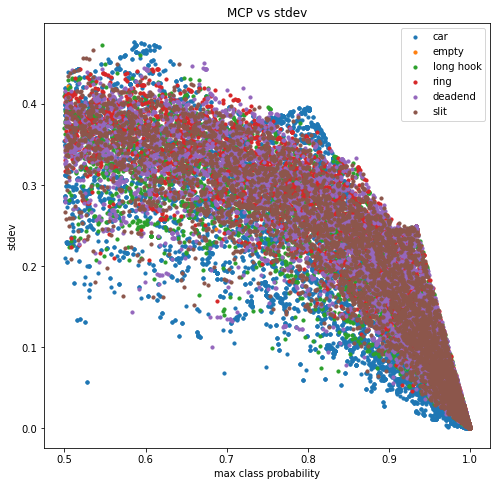

In [20]:
_, ax = plt.subplots(figsize=(8,8))
ax.set_title(f'MCP vs stdev')
ax.set_xlabel("max class probability")
ax.set_ylabel("stdev")
ax.set_aspect("equal")
# ax.plot([0, 0.5], [0, 0.5], c='k')
# ax.plot([0.5, 1.0], [0.5, 0.0], c='k')
# ax.plot([0, 1.0], [0.25, 0.5], c='k')
# ax.plot([0.0, 1.0], [0.5, 0.25], c='k')
# ax.plot([0, 0.3], [0.0, 0.5], c='k')
for name, df in dfs.items():
    probabilities = df['probabilities']
    stdevs = df['stdevs']
    mcp = make_max_class_prob(probabilities)

    ax.scatter(mcp, stdevs, label=f'{name}', s=10)

ax.legend()